In [1]:
# Basic necessary imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2

In [2]:
# Prepare paths of input images and target segmentation masks
input_dir = "./images/render/"
target_dir = "./images/clean/" 
img_size = (160, 160)          #720x480 divided by 2
num_classes = 4
batch_size = 32

# Sorting image names in input folder
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".png")
])

#Sorting mask names in target folder
target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
])

print("Number of samples:", len(input_img_paths))

#Input and target images are now corresponding
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 9766
./images/render/render0001.png | ./images/clean/clean0001.png
./images/render/render0002.png | ./images/clean/clean0002.png
./images/render/render0003.png | ./images/clean/clean0003.png
./images/render/render0004.png | ./images/clean/clean0004.png
./images/render/render0005.png | ./images/clean/clean0005.png
./images/render/render0006.png | ./images/clean/clean0006.png
./images/render/render0007.png | ./images/clean/clean0007.png
./images/render/render0008.png | ./images/clean/clean0008.png
./images/render/render0009.png | ./images/clean/clean0009.png
./images/render/render0010.png | ./images/clean/clean0010.png


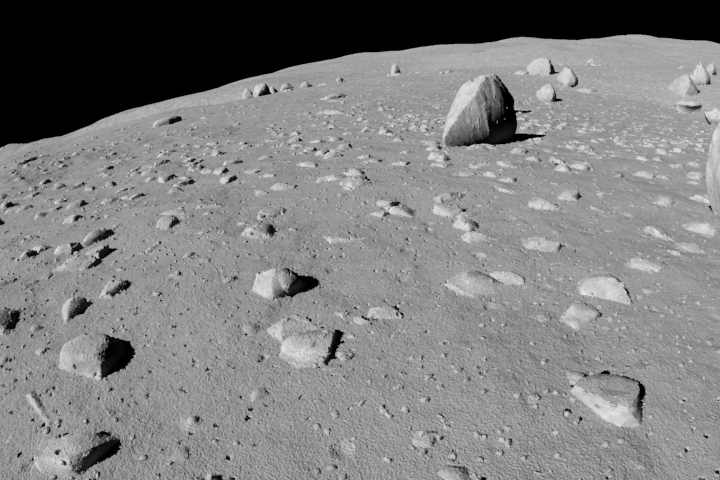

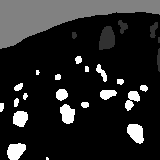

(160, 160, 1)
[0 1 2 3]


In [3]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

image_index = 10

# Display input image 
display(Image(filename=input_img_paths[image_index]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[image_index], target_size = img_size, color_mode="grayscale"))
display(img)

img_arr = np.array(img)
                # Map pixel colors onto labels -- haven't found any better way yet
for k in range(img_arr.shape[0]):
    for n in range(img_arr.shape[1]):
        if img_arr[k][n] == 49:
            img_arr[k][n] = 1
        elif img_arr[k][n] == 129:
            img_arr[k][n] = 2
        elif img_arr[k][n] == 255:
            img_arr[k][n] = 3
        elif img_arr[k][n] != 0:
            img_arr[k][n] = 0
img_arr = np.expand_dims(img_arr, 2)
print(img_arr.shape)
print(np.unique(img_arr))


In [4]:
# Prepare Sequence class to load and vectorize batches of data

class LunarLandscape(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        # Returns tuple (input, target) corresponding to batch idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # 3 Dimensional input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            if img is None:
                print("Loading image failed on: ", path)
            else:
                x[j] = img
                
        # 1 Dimensional target mask
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = PIL.ImageOps.autocontrast(load_img(path, target_size = self.img_size, color_mode="grayscale"))
            img_arr = np.array(img)
            # Map pixel colors onto labels -- haven't found any better way yet
            for k in range(img_arr.shape[0]):
                for n in range(img_arr.shape[1]):
                    if img_arr[k][n] == 49:
                        img_arr[k][n] = 1
                    elif img_arr[k][n] == 129:
                        img_arr[k][n] = 2
                    elif img_arr[k][n] == 255:
                        img_arr[k][n] = 3
                    elif img_arr[k][n] != 0:
                        img_arr[k][n] = 0
            img_arr = np.expand_dims(img_arr, 2)
            y[j] = img_arr
                
        return x, y


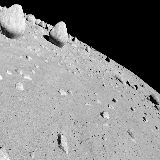

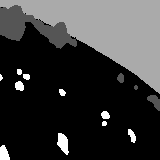

In [7]:
loader = LunarLandscape(
            batch_size, img_size, train_input_img_paths, train_target_img_paths)

# print(np.unique(loader.__getitem__(1)[1][3]))
batch = loader.__getitem__(2)
display(keras.utils.array_to_img(batch[0][2]))
display(keras.utils.array_to_img(batch[1][2]))

In [6]:
import random
# Split image paths into training and validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiane data Sequences for each split
train_gen = LunarLandscape(
            batch_size, img_size, train_input_img_paths, train_target_img_paths)

val_gen = LunarLandscape(
            batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [8]:
# Define model
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3, ))
    #First half of the network: downsampling inputs
    
    #Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x #set aside residual
    
    #Blocks 1, 2, 3 are idencital apart from the feature depth
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        #Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation) 
        x = layers.add([x, residual]) #Add back residual
        previous_block_activation = x #Set aside next residual
        
    # Second half of the network: upsampling inputs
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)
        
        #Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual]) # Add back residaul
        previous_block_activation = x #set aside next residual
    
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

#Build the model
model = get_model(img_size, num_classes)
model.summary()

2022-08-04 16:25:55.701962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 16:25:55.784936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 16:25:55.785164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 16:25:55.786579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 10, 10, 256)  590080     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 10, 10, 256)  1024       ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 10, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_8[0][0]']           
 spose)   

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 80, 80, 32)  9248        ['activation_14[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 160, 160, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 up_sampli

In [9]:
# Compile model
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",
#              metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("lunar_segmentation.h5", save_best_only=True)
]

epochs = 15
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


2022-08-04 16:26:47.169014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-04 16:26:48.760951: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-04 16:26:49.274447: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-04 16:26:49.328086: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

273/273 [==============================] - 1042s 4s/step - loss: 0.5563 - val_loss: 0.7231
Epoch 2/15
273/273 [==============================] - 998s 4s/step - loss: 0.2655 - val_loss: 0.3067
Epoch 3/15
273/273 [==============================] - 1004s 4s/step - loss: 0.2316 - val_loss: 0.4936
Epoch 4/15
273/273 [==============================] - 1012s 4s/step - loss: 0.2107 - val_loss: 0.2493
Epoch 5/15
273/273 [==============================] - 995s 4s/step - loss: 0.1994 - val_loss: 0.5216
Epoch 6/15
273/273 [==============================] - 998s 4s/step - loss: 0.1887 - val_loss: 0.1950
Epoch 7/15
273/273 [==============================] - 1007s 4s/step - loss: 0.1770 - val_loss: 0.2266
Epoch 8/15
273/273 [==============================] - 993s 4s/step - loss: 0.1685 - val_loss: 0.6723
Epoch 9/15
273/273 [==============================] - 991s 4s/step - loss: 0.1562 - val_loss: 0.2132
Epoch 10/15
273/273 [==============================] - 1018s 4s/step - loss: 0.1486 - val_loss: 0.

<AxesSubplot:>

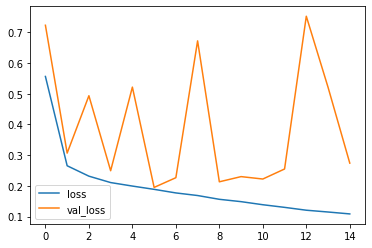

In [10]:
history_df = pd.DataFrame(history.history)
history_df.plot()

In [25]:
def display_mask(i):
    #Quick utilization to display a model's prediction

    mask = np.argmax(val_preds[i], axis=2)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)

In [12]:
#Generate predictions
val_gen = LunarLandscape(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


31/31 [==============================] - 108s 3s/step


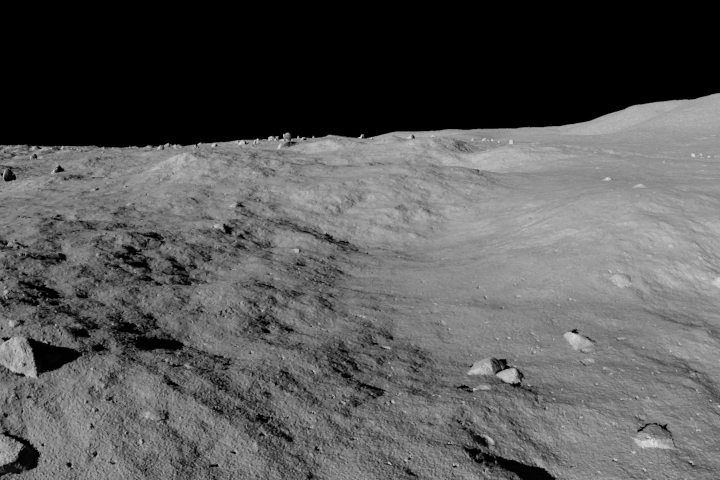

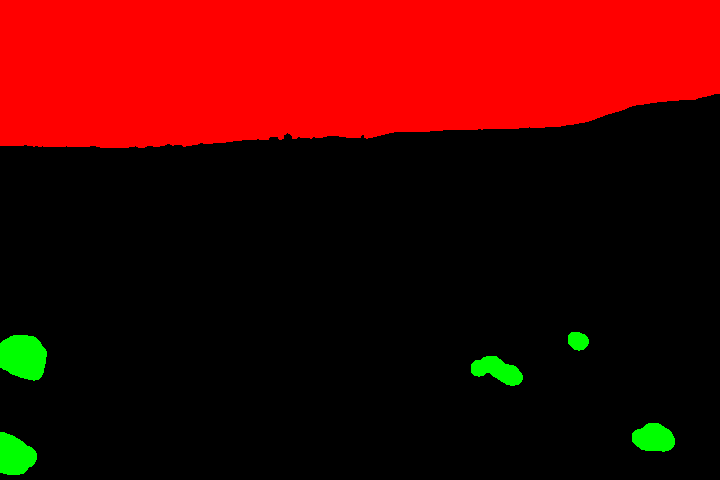

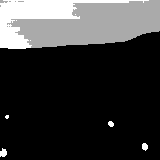

In [32]:
    # Display results for validation image 19
i = 11

# Display input image
display(Image(filename=val_input_img_paths[i]))

#Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by model
display_mask(i) # Model only sees inputs at 160x160

In [13]:
model_loaded = keras.models.load_model('lunar_segmentation.h5')
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 10, 10, 256)  590080     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 10, 10, 256)  1024       ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 10, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_8[0][0]']           
 spose)   

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 80, 80, 32)  9248        ['activation_14[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 160, 160, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 up_sampli

In [18]:
val_gen = LunarLandscape(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model_loaded.predict(val_gen)

31/31 [==============================] - 105s 3s/step


# Plan na dalsze prace:

- Ogarnąć zbiór danych, wyodrębnić więcej kamyków z ground truth oraz zapisać to czystszej postaci
- Odpalić albo utworzyć metrykę IoU tak aby dawała wymierne rezultaty
- dalej rozwijać model tzn:
    - utworzyć nowy model z wytrenowaną konwolucyjną bazą, może to być ten EfficentDet
    - spróbować całkowicie przetrenować już wcześniej utworzony model ale przerobiony pod segmentacje
  - ogarnąć sensowniejsze zapisywanie modeli
  - poszukać innych zbiorów danych na których można odpalić wytenowany model
  - zacząć zbierać literaturę ogólnie do pisania pracy
  
 ## Pytania na konsultacje:
 
 - Co zrobić dokładnie z tym zbiorem co jest teraz? Zostać przy clean images czy robić samemu (i tak zobaczę co można samemu zrobić)
 - jaka będzie najlepsza baza czy architektura do tego problemu?
 - ogólnie czy tak wykonany projekt jest dobrym podejściem czy raczej coś pozmieniać
 - co robić dalej? Tzn czy próbować to może odpalić na raspberry czy może znaleźć inną metrykę do ewaluacji wydajności?
 - zapytać też o ten EfficentDet, idziemy konkretnie w tym kierunku czy raczej to zostawiamy?
 - co z tradycyjnymi podejściami, też bieżemy pod uwagę np. algorytm knn?
 